In [30]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
import os
import numpy as np
from fastai.text.all import *

In [37]:
# Load pre-trained model and tokenizer from Hugging Face
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

In [5]:
# Ensure model uses the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [12]:
DIR_PATH = "/home/salla/Downloads/text-gen/poems"

def traverse_directory(root_dir, folder_name, type):
    haiku = []
    for dir_name in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, dir_name)
        if os.path.isdir(dir_path) and dir_name == folder_name:
            for sub_dir_name in os.listdir(dir_path):
                sub_dir_path = os.path.join(dir_path, sub_dir_name)
                if os.path.isdir(sub_dir_path) and sub_dir_name == type:
                    for filename in os.listdir(sub_dir_path):
                        file_path = os.path.join(sub_dir_path, filename)
                        print("Processing file:", file_path)
                        haiku.append(file_path)
    return haiku

haiku = traverse_directory(DIR_PATH, "forms", "haiku")
print("Collected haiku files:", haiku)

Processing file: /home/salla/Downloads/text-gen/poems/forms/haiku/HaikuPoemsAHawkHaikuHaikuHaikuHaikuHaikuPoembyUdiahwitnesstoYah.txt
Processing file: /home/salla/Downloads/text-gen/poems/forms/haiku/HaikuPoemsHaikuTheJoyToBeAnimalPoembyjohntiongchunghoo.txt
Processing file: /home/salla/Downloads/text-gen/poems/forms/haiku/HaikuPoemshaikusexyHaikuPoembychrisbowenakatowit.txt
Processing file: /home/salla/Downloads/text-gen/poems/forms/haiku/HaikuPoemsHaikuMichaelJacksonsTrialPoembyjohntiongchunghoo.txt
Processing file: /home/salla/Downloads/text-gen/poems/forms/haiku/HaikuPoemsHaikuACaterpillarPoembyjohntiongchunghoo.txt
Processing file: /home/salla/Downloads/text-gen/poems/forms/haiku/HaikuPoemsHaikuBirdsSingingPoembyJackKerouac.txt
Processing file: /home/salla/Downloads/text-gen/poems/forms/haiku/HaikuPoemsHaikuTheMorningGloryAlsoPoembyjohntiongchunghoo.txt
Processing file: /home/salla/Downloads/text-gen/poems/forms/haiku/HaikuPoemsHaikuSeawavesPaintersBrushPoembyjohntiongchunghoo.txt

In [13]:
len(haiku)

99

In [17]:
first_poem_path = haiku[0]
with open(first_poem_path, 'r') as file:
    first_poem = file.read()
print("First poem contents:\n", first_poem)

First poem contents:
 The harvest soon comes
A hawk's eye is needed now
Two watching a front


In [21]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i, list):
            rt.extend(flatten(i))
        else:
            rt.append(i)
    return rt

In [23]:
# Read all haiku poems and store them in a list
haiku_poems = [open(poem_path, 'r').read() for poem_path in haiku]

# Assuming haiku_poems may have a nested structure, we flatten it
flattened_haiku_poems = flatten(haiku_poems)

# Convert the flattened list of haiku poems to a NumPy array
haiku_array = np.array(flattened_haiku_poems)

print("Collected haiku poems in NumPy array:")
print(haiku_array)

Collected haiku poems in NumPy array:
["The harvest soon comes\nA hawk's eye is needed now\nTwo watching a front"
 'animal joy\nfreedom from\nall guilts'
 'open sesame\nride her in, bind her up good\ntake the time of her'
 "michael jackson's trial\nthis time he sings\nthey are not my lovers"
 'A caterpillar\nthe child wonders\nhow it controls its legs'
 'Birds singing\nin the dark\n—Rainy dawn.'
 'breeze\nthe morning glory touches\nmy heart'
 "sea waves\npainter's brush\ndances over the canvas\nwaves\nfrom his palette\nthe beach appears"
 "sea\nhe disperses waves of blue over\nhis canvas\ninspired from these quotes:\nquopo #1057: Where nature ends\nGreat art picks up where nature ends.\n==Marc Chagall\nThe aim of art is to represent not the outward\nappearance of things, but their inward significance.\n==Aristotle\nArt is a technique of communication. The image is\nthe most complete technique of all communication.\n==Claus Oldenburg\nArt hurts. Art urges voyages—\nand it is easier to s

In [31]:
class TransformerTokenizer(Transform):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return torch.tensor(self.tokenizer.convert_tokens_to_ids(toks))
    
    def decodes(self, x):
        return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

# Create an instance of the TransformerTokenizer
transformer_tokenizer = TransformerTokenizer(tokenizer)

# Example of encoding and decoding the first haiku
first_haiku = haiku_array[0]
encoded_first_haiku = transformer_tokenizer.encodes(first_haiku)
decoded_first_haiku = transformer_tokenizer.decodes(encoded_first_haiku)

print("First haiku:")
print(first_haiku)
print("Encoded first haiku:")
print(encoded_first_haiku)
print("Decoded first haiku:")
print(decoded_first_haiku)


First haiku:
The harvest soon comes
A hawk's eye is needed now
Two watching a front
Encoded first haiku:
tensor([  464, 13222,  2582,  2058,   198,    32, 48710,   338,  4151,   318,
         2622,   783,   198,  7571,  4964,   257,  2166])
Decoded first haiku:
The harvest soon comes
A hawk's eye is needed now
Two watching a front


In [45]:
splits = [range_of(69), range(69, 99)]  # 70/30 split

tls = TfmdLists(haiku_array, TransformerTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [46]:
show_at(tls.train, 0)

The harvest soon comes
A hawk's eye is needed now
Two watching a front


In [47]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [49]:
dls.show_batch(max_n=2)

,text,text_
0,"a cold autumn rain\ncaught them unexpectedly\nnow searching a tree1.\nmind's edge blunted\ndesert devoid of markers\nmy tears wet dry sand\nJuly 29,2014\n2.\nseasonal picture\ndon't let me add a thing please\nyour haiku not mine\nJune 6,2016\n3.\nmissing photographs\nreal content camera shy\nskit artist needed\nJune 6,2016Mount Fujiyama\nCherry Trees in Blossom\nA Couple in Love American Western Haiku On a mountain peak\nStood a mountain goat king\nSubjects all belowmist\ngathering water\nmy eyelashes\ninspired by:\nMist\nLow-anchored cloud,\nNewfoundland air,\nFountain head and source of rivers,\nDew-cloth, dream drapery,\nAnd napkin spread by fays;\nDrifting meadow of the air,\nWhere bloom the dasied banks and violets,\nAnd in whose fenny labyrinth\nThe bittern booms and heron wades;\nSpirit of the lake and seas and rivers,\nBear only purfumes and the scent\nOf healing herbs to just men's fields!\nHenry David Thoreau","cold autumn rain\ncaught them unexpectedly\nnow searching a tree1.\nmind's edge blunted\ndesert devoid of markers\nmy tears wet dry sand\nJuly 29,2014\n2.\nseasonal picture\ndon't let me add a thing please\nyour haiku not mine\nJune 6,2016\n3.\nmissing photographs\nreal content camera shy\nskit artist needed\nJune 6,2016Mount Fujiyama\nCherry Trees in Blossom\nA Couple in Love American Western Haiku On a mountain peak\nStood a mountain goat king\nSubjects all belowmist\ngathering water\nmy eyelashes\ninspired by:\nMist\nLow-anchored cloud,\nNewfoundland air,\nFountain head and source of rivers,\nDew-cloth, dream drapery,\nAnd napkin spread by fays;\nDrifting meadow of the air,\nWhere bloom the dasied banks and violets,\nAnd in whose fenny labyrinth\nThe bittern booms and heron wades;\nSpirit of the lake and seas and rivers,\nBear only purfumes and the scent\nOf healing herbs to just men's fields!\nHenry David Thoreausun"
1,"'s peace ring\nfor the first time\ninspired by\nrose garden\nI’ve forgotten which one\nis called Peaceour treetop moments\nperched on my memory still....\nbird of unclipped wingsat the full moon's\nrising, the silver-plumed\nreeds trembleBirds singing\nin the dark\n—Rainy dawn.All haiku writers\nPlease take note and don’t do this:\nCircumlocution\n10th May 2009\nCopyright © SCspring rain:\nbrowsing under an umbrella\nat the picture-book storescatter layer\nby layer, eight-layered\ncherry blossoms!in silence\nher cry\nfor love\nin silence\nshe cries out\nfor lovebreeze\nthe morning glory touches\nmy heartYour ever lasting\nkiss touched my soul long before\nwe had ever met.Imperceptible\nat first, sunlight changing; then\ndusky, or faded,\nfilter on the lens\nencroaching, sky blue into\ngrey, then grey-lilac,\ncolours blur, textures,\nshadows cast paler, out of\nfocus, sudden cold\nstrikes us uneasy,\n","peace ring\nfor the first time\ninspired by\nrose garden\nI’ve forgotten which one\nis called Peaceour treetop moments\nperched on my memory still....\nbird of unclipped wingsat the full moon's\nrising, the silver-plumed\nreeds trembleBirds singing\nin the dark\n—Rainy dawn.All haiku writers\nPlease take note and don’t do this:\nCircumlocution\n10th May 2009\nCopyright © SCspring rain:\nbrowsing under an umbrella\nat the picture-book storescatter layer\nby layer, eight-layered\ncherry blossoms!in silence\nher cry\nfor love\nin silence\nshe cries out\nfor lovebreeze\nthe morning glory touches\nmy heartYour ever lasting\nkiss touched my soul long before\nwe had ever met.Imperceptible\nat first, sunlight changing; then\ndusky, or faded,\nfilter on the lens\nencroaching, sky blue into\ngrey, then grey-lilac,\ncolours blur, textures,\nshadows cast paler, out of\nfocus, sudden cold\nstrikes us uneasy,\nhalf"


## Fine Tuning

In [50]:
class DropOutput(Callback):
    def after_pred(self):
        self.learn.pred = self.pred[0]

In [51]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [52]:
learn.validate()

/home/salla/Downloads/text-gen/.venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/home/salla/Downloads/text-gen/.venv/lib/python3.11/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


(#2) [3.555706739425659,35.01255416870117]

SuggestedLRs(valley=0.00019054606673307717)

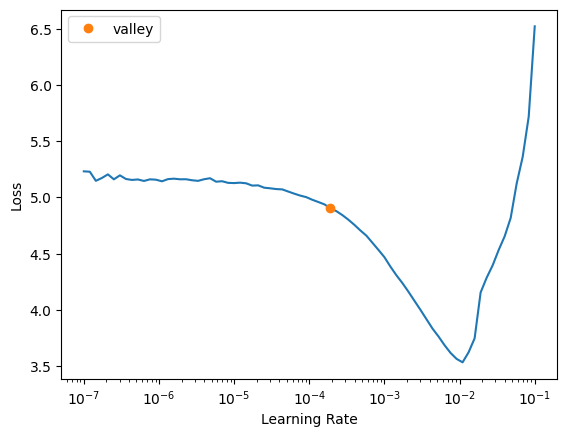

In [53]:
learn.lr_find()

In [54]:
learn.fit_one_cycle(1, 1e-4)

epoch     train_loss  valid_loss  perplexity  time    
0         5.152991    3.482473    32.540085   00:19                                    


## Example

In [56]:
prompt = 'love is ridiculous' # create an initial text prompt to start your generated text
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cpu()
inp.shape

torch.Size([1, 3])

In [57]:
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
love is ridiculous."

"I don't know what you're talking about," she said. "I mean, it's not like I've ever seen anything like that before. It's like, 'Oh, you know, I'm going to have to do something about it.' "



In [60]:
prompt = "Tejesh"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cpu()
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
Tejesh.

"I'm not going to tell you what to do," he said. "I don't want to hurt you. I want you to know that I'm here to help you, and I will do everything in my power to make sure that you're safe."
